# Modèle 4 : Le climat du futur 

## Présentation

## Le modèle 

In [19]:
import numpy 
import matplotlib.pyplot as plt 
import math 

class Projection():

    def __init__(self,year_for_change=2020):

        # Paramètres
        self.timeStep = 5       # pas de temps [an]
        self.eqCO2 = 280        # concentration en CO2 à l'équilibre [ppm] 
        self.initCO2 = 290      # concentration en CO2 initiale [ppm]
        self.CO2_exp = 0.0225   # taux de croissance [/an]
        self.CO2RampExp = 0.01  # taux de rabattement [/an]
        self.aerosol_Wm2_now = -0.75  # forçage radiatif des aérosols [W/m2]
        self.watts_m2_2x = 4
        self.climateSensitivity2x = 3  # sensibilité climatique pour un changement de T équivalent à un doublement de CO2 (soit: FR = 4 W/m2)
        self.climateSensitivityWm2 = self.climateSensitivity2x / self.watts_m2_2x  # changement de T par W/m2 de forçage 
        self.TResponseTime = 20  # combinaison entre équilibrage rapide (océan superficiel) et équilibrage lent (océan profond) 

        
        # Variables
        self.years = [1900]
        
        # Scénario "Business-as-usual"
        # CO2 atmosphérique
        self.bauCO2 = [self.initCO2]
        self.inoCO2 = [0]
        # Forçages radiatifs pour le scénario "business-as-usual"
        self.rfCO2 = [0]
        self.rfMask = [0]
        self.rfTot = [0]
        # Températures
        self.Teq = [0]
        self.TTrans = [0]
        
        # Scénario "World without us"
        # CO2 atmosphérique
        self.rampCO2 = [self.initCO2]
        # Forçages radiatifs pour le scénario "world without us"
        self.rfCO2Ramp = [0]
        self.rfMaskRamp = [0]
        self.rfTotRamp = [0]
        # Températures
        self.TeqRamp = [0]
        self.TTransRamp = [0]

        
        # Exécution de la routine "scenario" (paramètre: année de cessation des émissions)
        self.scenario(year_for_change)

        
    def scenario(self,year_for_change):

        # Scénario BUSINESS AS USUAL

        while self.years[-1] < 2100:
            # Création d'une liste d'années allant de 1900 à 2100 avec un pas de 1 an
            self.years.append(self.years[-1] + self.timeStep )
            # Calcul des concentrations de CO2 
            self.bauCO2.append(self.eqCO2 + (self.bauCO2[-1] - self.eqCO2) * (1 + self.CO2_exp * self.timeStep))
            self.inoCO2.append( (self.bauCO2[-1] - self.bauCO2[-2]) / self.timeStep )
            # Calcul du forçage radiatif associé à la hausse de concentration de CO2 
            self.rfCO2.append(self.watts_m2_2x * math.log( self.bauCO2[-1]/self.eqCO2 ) / math.log(2) )

        # Recherche de l'indice de l'année de cessation des émissions de CO2 dans la liste d'années
        iyrfc = self.years.index(year_for_change)
        # Calcul de la valeur de "B" tel que B*taux de croissance des émissions de CO2 actuel = FR 
        aerosolCoeff = self.aerosol_Wm2_now / ( (self.bauCO2[iyrfc] - self.bauCO2 [iyrfc - 1]) / self.timeStep )

        for i in range(1, len(self.years)):
            # Calcul de l'effet masque (effet radiatif aérosols + GES à courte durée de vie) 
            self.rfMask.append( max(self.inoCO2[i] * aerosolCoeff, self.aerosol_Wm2_now))
            # Calcul du forçage radiatif total : FR CO2 + FR masque
            self.rfTot.append( self.rfCO2[i] + self.rfMask[i] )
            # Calcul de T équilibre à partir de FR total (en supposant qu'il est gardé constant suffisamment longtemps pour atteindre l'équilibre)
            self.Teq.append( self.rfTot[i] * self.climateSensitivityWm2)
            # Calcul de T "transitoire" (T ne s'équilibre pas instantannément principalement à cause du rôle intégrateur des océans)
            self.TTrans.append( self.TTrans[-1] + (self.Teq[i] - self.TTrans[-1]) * self.timeStep / self.TResponseTime )

        # Scénario WORLD WITHOUT US
        for i in range(1, iyrfc):
            # Copie des variables du scénario "Business as usual" jusqu'au point où les émissions divergent 
            # Variables copiées : concentrations en CO2, FR CO2, T équilibre et T transitoire 
            self.rampCO2.append( self.bauCO2[i] )
            self.rfCO2Ramp.append( self.rfCO2[i] )
            self.rfMaskRamp.append( self.rfMask[i] )
            self.TTransRamp.append( self.TTrans[i] )
            self.TeqRamp.append( self.Teq[i] )
            self.rfTotRamp.append( self.rfTot[i] )

        # Calcul de la décroissance de concentration en CO2 et du FR associé
        # NB: l'effet masque n'est plus pris en compte -> court terme (déposition des aérosols et courte durée de vie des GES autres que CO2) 
        # Le changement de T débute l'année de cessation des émissions de CO2 
        for i in range(iyrfc, len(self.years)):
            self.rampCO2.append( self.rampCO2[-1] + (self.eqCO2*1.2 - self.rampCO2[-1]) * (self.CO2RampExp * self.timeStep) )
            self.rfCO2Ramp.append( self.watts_m2_2x * math.log(self.rampCO2[i]/self.eqCO2) / math.log(2) )
            self.rfMaskRamp.append( 0 )
            self.rfTotRamp.append( self.rfCO2Ramp[i] )
            self.TeqRamp.append( self.rfCO2Ramp[i] * self.climateSensitivityWm2 )
            self.TTransRamp.append( self.TTransRamp[-1] + (self.TeqRamp[i] - self.TTransRamp[-1]) * self.timeStep / self.TResponseTime )

            
    def plot(self):

        #self.scenario(year_for_change)

        # Graphique : émissions de CO2
        plt.figure(figsize=(5,5))
        plt.title('Emissions de CO2',fontweight='bold')
        plt.plot(self.years,self.bauCO2,'-r',label='business as usual')
        plt.plot(self.years,self.rampCO2,'-g',label='mitigation')
        plt.xlabel('années')
        plt.ylabel('CO2 [ppm]')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

        # Graphique : forçage radiatif
        plt.figure(figsize=(5,5))
        plt.title('Forçage radiatif du CO2',fontweight='bold')
        plt.plot(self.years,self.rfTot,'-r',label='business as usual')
        plt.plot(self.years,self.rfTotRamp,'-g',label='mitigation')
        plt.xlabel('années')
        plt.ylabel('FR [W/m²]')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

        # Graphique : température
        plt.figure(figsize=(5,5))
        plt.title('Réponse en température',fontweight='bold')
        plt.plot(self.years,self.TTrans,'-r',label='business as usual')
        plt.plot(self.years,self.TTransRamp,'-g',label='mitigation')
        plt.xlabel('années')
        plt.ylabel('\u0394 T [°C]')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()


## Application

In [20]:
p2020 = Projection(2020)
p2030 = Projection(2030)
p2040 = Projection(2040)
p2050 = Projection(2050)

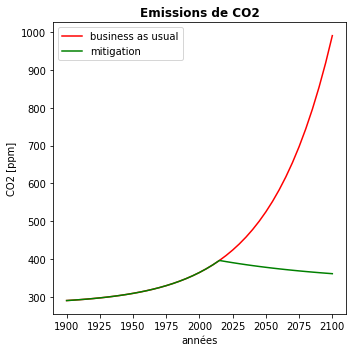

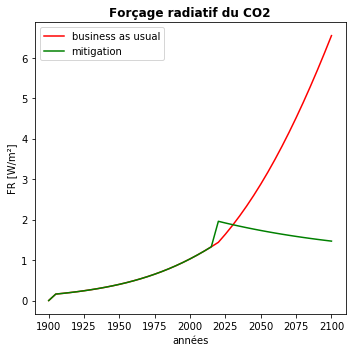

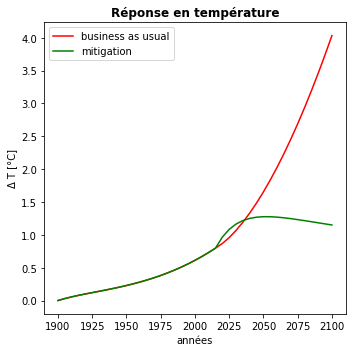

In [21]:
p2020.plot()

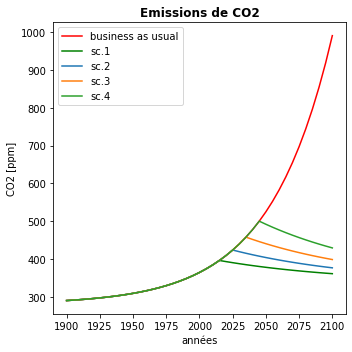

In [22]:
plt.figure(figsize=(5, 5))
plt.title('Emissions de CO2', fontweight='bold')
plt.plot(p2020.years, p2020.bauCO2, '-r', label='business as usual')
plt.plot(p2020.years, p2020.rampCO2, '-g', label='sc.1')
plt.plot(p2030.years, p2030.rampCO2, label='sc.2')
plt.plot(p2040.years, p2040.rampCO2, label='sc.3')
plt.plot(p2050.years, p2050.rampCO2, label='sc.4')
plt.xlabel('années')
plt.ylabel('CO2 [ppm]')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

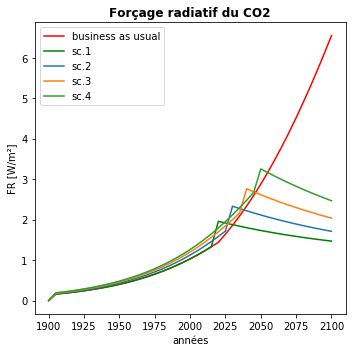

In [23]:
plt.figure(figsize=(5, 5))
plt.title('Forçage radiatif du CO2', fontweight='bold')
plt.plot(p2020.years, p2020.rfTot, '-r', label='business as usual')
plt.plot(p2020.years, p2020.rfTotRamp, '-g', label='sc.1')
plt.plot(p2030.years, p2030.rfTotRamp, label='sc.2')
plt.plot(p2040.years, p2040.rfTotRamp, label='sc.3')
plt.plot(p2050.years, p2050.rfTotRamp, label='sc.4')
plt.xlabel('années')
plt.ylabel('FR [W/m²]')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

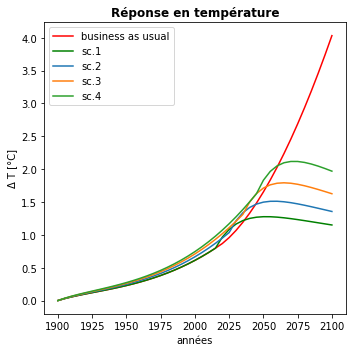

In [24]:
plt.figure(figsize=(5, 5))
plt.title('Réponse en température', fontweight='bold')
plt.plot(p2020.years, p2020.TTrans, '-r', label='business as usual')
plt.plot(p2020.years, p2020.TTransRamp, '-g', label='sc.1')
plt.plot(p2030.years, p2030.TTransRamp, label='sc.2')
plt.plot(p2040.years, p2040.TTransRamp, label='sc.3')
plt.plot(p2050.years, p2050.TTransRamp, label='sc.4')
plt.xlabel('années')
plt.ylabel('\u0394 T [°C]')
plt.legend(loc='best')
plt.tight_layout()
plt.show()